In [1]:
#install required packages
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

2.1.0


In [2]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,)
    plt.show()

In [3]:
dir = '/mnt/data1/karres/cosmics_test/feature_store_cosmic/'
data = torch.load(dir+'trainset/truth_graphs/event000000053-graph.pyg')

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
#print(f'Has isolated nodes: {data.has_isolated_nodes()}')
#print(f'Has self-loops: {data.has_self_loops()}')
#print(f'Is undirected: {data.is_undirected()}')

Data(x=[6, 4], edge_index=[2, 5], y=[6, 4])
Number of nodes: 6
Number of edges: 5
Average node degree: 0.83


In [4]:
import pandas as pd

# Sample data
data = {
    'particle_id': [1, 1, 1, 1, 1, 1, 1, 1, 3, 3],
    'layer': ['3', '2', '1', '0', '0', '1', '2', '3', '3', '3'],
    'station': ['0', '0', '0', '0', '0', '0', '0', '0', '-1', '-1'],
    'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'other stuff': ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
}

signal = pd.DataFrame(data)
module_columns = ['layer', 'station']

# Grouping and aggregating
grouped = signal.groupby(['particle_id'] + module_columns, sort=False)['index'].agg(lambda x: list(x))
print(grouped)
print('===================')


grouped_again = grouped.groupby(level=0).agg(lambda x: list(x))
print(grouped_again)
print('===================')

signal_index_list = (grouped_again)
print(signal_index_list)
print('===================')

print(signal_index_list.values)

row = signal_index_list.values[1]
print(row[:-1])
print(row[1:])
print('===================')

from itertools import product
track_index_edges = []
for row in signal_index_list.values:
        
        for i, j in zip(row[:-1], row[1:]):
            track_index_edges.extend(list(product(i, j)))   

print(track_index_edges)

particle_id  layer  station
1            3      0          [0, 7]
             2      0          [1, 6]
             1      0          [2, 5]
             0      0          [3, 4]
3            3      -1         [8, 9]
Name: index, dtype: object
particle_id
1    [[0, 7], [1, 6], [2, 5], [3, 4]]
3                            [[8, 9]]
Name: index, dtype: object
particle_id
1    [[0, 7], [1, 6], [2, 5], [3, 4]]
3                            [[8, 9]]
Name: index, dtype: object
[list([[0, 7], [1, 6], [2, 5], [3, 4]]) list([[8, 9]])]
[]
[]
[(0, 1), (0, 6), (7, 1), (7, 6), (1, 2), (1, 5), (6, 2), (6, 5), (2, 3), (2, 4), (5, 3), (5, 4)]


In [24]:
import pandas as pd
import numpy as np
from itertools import product
import torch
from torch_geometric.data import Data

dir = '/mnt/data1/karres/cosmics_test/feature_store_cosmic/'
example_event = pd.read_csv(dir+'trainset/csv/event000000002-truth.csv')

def process_hits(hits):
        #Rename tid and layer
        hits = hits.rename(columns={'tid': 'particle_id'})
        hits = hits.rename(columns={'layer': 'layer_id'})

        # Calculate the pT of the particle
        hits['pt'] = np.sqrt(hits["px"] ** 2 + hits["py"] ** 2)

        # Calculate the radius of the particle
        hits['radius'] = np.sqrt(hits["vx"] ** 2 + hits["vy"] ** 2)

        #Assign nhits
        hits['nhits'] = len(hits['x'])

        # Assign hit_ids
        hits['hit_id'] = list(range(1,len(hits['x'])+1))

        #Assign station_id: -1 for upstream recoil, 0 for central and +1 for downstream recurl station
        conditions = [(hits['z'] < -200), (hits['z'] < 200), (hits['z'] >= 200)]
        ids = [-1, 0, 1]
        hits['station_id'] = np.select(conditions, ids)

        #Assign ladder_id:
        hits['ladder_id'] = list(range(1,len(hits['x'])+1))
    
        return hits

def remap_edges(track_edges, track_features, hits):
        """
        Here we do two things:
        1. Remove duplicate hits from the hit list (since a hit is a node and therefore only exists once), and remap the corresponding truth track edge indices
        2. Remove duplicate truth track edges. This is a SMALL simplification for conceptual simplicity,
        but we apply a test to ensure the simplification does not throw away too many duplicate edges.
        """

        unique_hid = np.unique(hits.hit_id)
        hid_mapping = np.zeros(unique_hid.max() + 1).astype(int)
        hid_mapping[unique_hid] = np.arange(len(unique_hid))

        hits = hits.drop_duplicates(subset="hit_id").sort_values("hit_id")

        track_edges = hid_mapping[track_edges]

        # Remove duplicate edges
        unique_track_edges, unique_track_edge_indices = np.unique(
            track_edges, axis=1, return_index=True
        )
        track_features = {
            k: v[unique_track_edge_indices] for k, v in track_features.items()
        }

        # This test imposes a limit to how we simplify the graph: We don't allow shared EDGES (i.e. two different particles can share a hit, but not an edge between the same two hits). We want to ensure these are in a tiny minority
        n_shared_edges = track_edges.shape[1] - unique_track_edges.shape[1]
        assert n_shared_edges < 50, "The number of shared EDGES is unusually high!"

        return unique_track_edges, track_features, hits

def build_graph(self, hits, tracks, track_features, event_id):
        """
        Builds a PyG data object from the hits, particles and tracks.
        """

        graph = Data()
        for feature in set(self.config["feature_sets"]["hit_features"]).intersection(
            set(hits.columns)
        ):
            graph[feature] = torch.from_numpy(hits[feature].values)

        graph.track_edges = torch.from_numpy(tracks)
        for feature in set(self.config["feature_sets"]["track_features"]).intersection(
            set(track_features.keys())
        ):
            graph[feature] = torch.from_numpy(track_features[feature])

        # Add config dictionary to the graph object, so every data has a record of how it was built
        graph.config = [self.config]
        graph.event_id = str(event_id)

        return graph

In [6]:
print('=====Raw hit data=====')
print(example_event)
print('==========================')

hits = process_hits(example_event)

print('=====Hit data after process_hits=====')
print(hits)
print('================')

hits = hits.assign(
            R=np.sqrt(
                (hits.x - hits.vx) ** 2
                + (hits.y - hits.vy) ** 2
                + (hits.z - hits.vz) ** 2
            )
        )

signal = hits[(hits.particle_id != 0)]
signal = signal.sort_values("R").reset_index(drop=False)

print()
print('=====Hit data after sorting by R=====')
print(signal)
print('===================')

=====Raw hit data=====
   event  layer  ladder  module  station          x          y           z  \
0      2      2       2       0        2 -50.322186  52.171955  354.160004   
1      2      2       4       1        2 -68.043694  23.938395  346.179993   
2      2      3       1       0        2 -33.974640  78.191750  361.470001   
3      2      3       7       1        2 -85.161835  -3.560488  338.470001   

            px           py          pz          vx          vy         vz  \
0 -2334.052246 -3342.965576 -956.682495  452.045044  798.244934  567.13269   
1 -2334.052246 -3342.965576 -956.682495  452.045044  798.244934  567.13269   
2 -2334.052246 -3342.965576 -956.682495  452.045044  798.244934  567.13269   
3 -2334.052246 -3342.965576 -956.682495  452.045044  798.244934  567.13269   

   pid    tid  mid  
0  -13  41880    0  
1  -13  41880    0  
2  -13  41880    0  
3  -13  41880    0  
=====Hit data after process_hits=====
   event  layer_id  ladder  module  station         

In [7]:
module_columns = ['layer_id', 'station_id', 'ladder_id']

signal_index_list = (
            signal.groupby(
                ["particle_id"] + module_columns,
                sort=False,
            )["index"]
            .agg(lambda x: list(x))
            .groupby(level=0)
            .agg(lambda x: list(x))
        )
print('=====signal_index_list after grouping and aggregating=====')
print(signal_index_list)
print('==================')

track_index_edges = []
for row in signal_index_list.values:
    for i, j in zip(row[:-1], row[1:]):
        track_index_edges.extend(list(product(i, j)))

print()
print('=====track_index_edges=====')
print(track_index_edges)
print(np.array(track_index_edges).T)
print('===============')

track_index_edges = np.array(track_index_edges).T

'''
track_edges = hits.hit_id.values[track_index_edges]


print()
print('======Track edges=====')
print(track_edges)
print('==================')
'''
track_features = {}

for track_feature in set(['particle_id', 'pt', 'radius', 'nhits']).intersection(set(hits.columns)):
    track_features[track_feature] = hits[track_feature].values[track_index_edges[0]]

print()
print('=====Track features======')
print(track_features)
print('===================')

'''
track_edges, track_features, hits = remap_edges(track_edges, track_features, hits)

print()
print('=====Track edges (remapped)=====')
print(track_edges)
print('=======================')
'''


=====signal_index_list after grouping and aggregating=====
particle_id
41880    [[2], [0], [1], [3]]
Name: index, dtype: object

=====track_index_edges=====
[(2, 0), (0, 1), (1, 3)]
[[2 0 1]
 [0 1 3]]

=====Track features======
{'particle_id': array([41880, 41880, 41880]), 'nhits': array([4, 4, 4]), 'pt': array([4077.1581685, 4077.1581685, 4077.1581685]), 'radius': array([917.35472776, 917.35472776, 917.35472776])}


"\ntrack_edges, track_features, hits = remap_edges(track_edges, track_features, hits)\n\nprint()\nprint('=====Track edges (remapped)=====')\nprint(track_edges)\nprint('=======================')\n"

In [25]:
from torch_geometric import utils
import networkx as nx
graph = Data()

#Create feature_matrix: shape(num_nodes, num_node_features)
feature_matrix = torch.from_numpy(hits[['hit_id', 'x', 'y', 'z']].values)
edge_index = torch.from_numpy(track_index_edges)
graph_features = torch.from_numpy(hits[['particle_id', 'pt', 'radius', 'nhits']].values)

graph.x = feature_matrix
graph.edge_index = edge_index
graph.y = graph_features

NameError: name 'hits' is not defined

Visualization 
Number of nodes: 120
Number of edges: 7140
Number of nodes: 120
Number of edges: 7086
Number of nodes: 120
Number of edges: 7086
Number of nodes: 120
Number of edges: 119


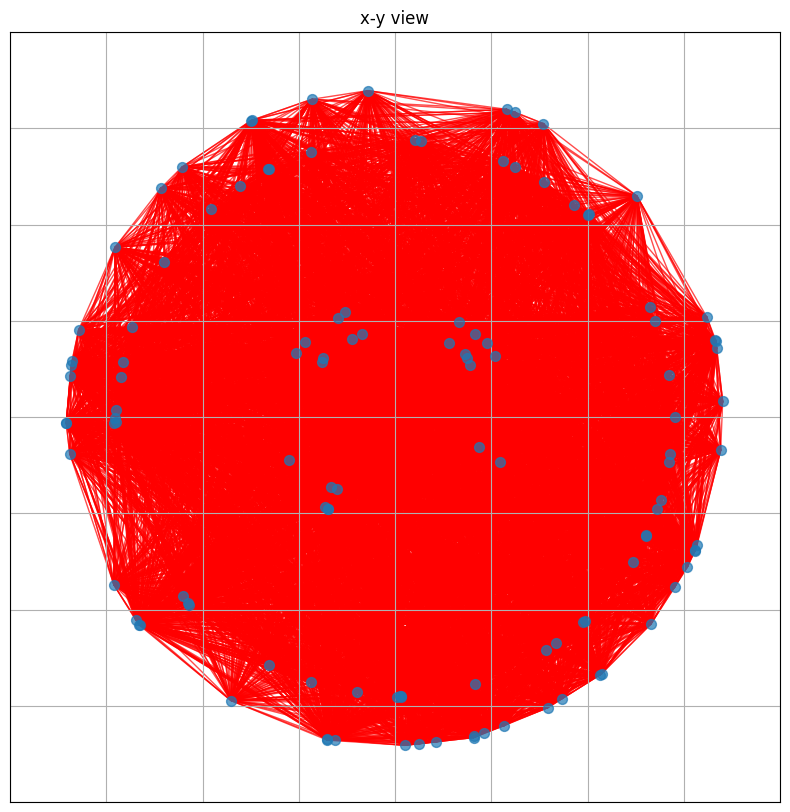

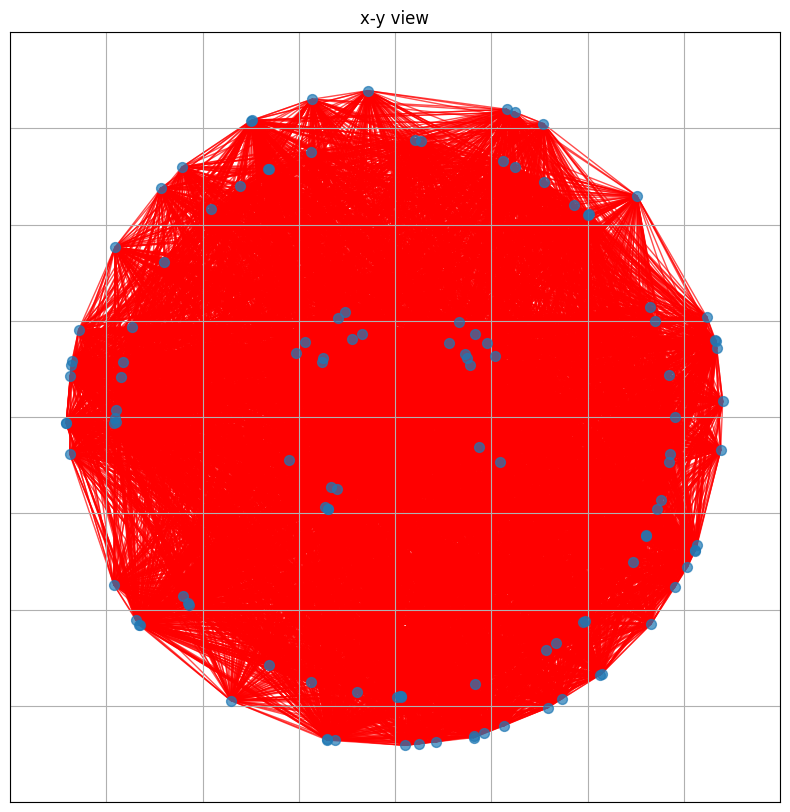

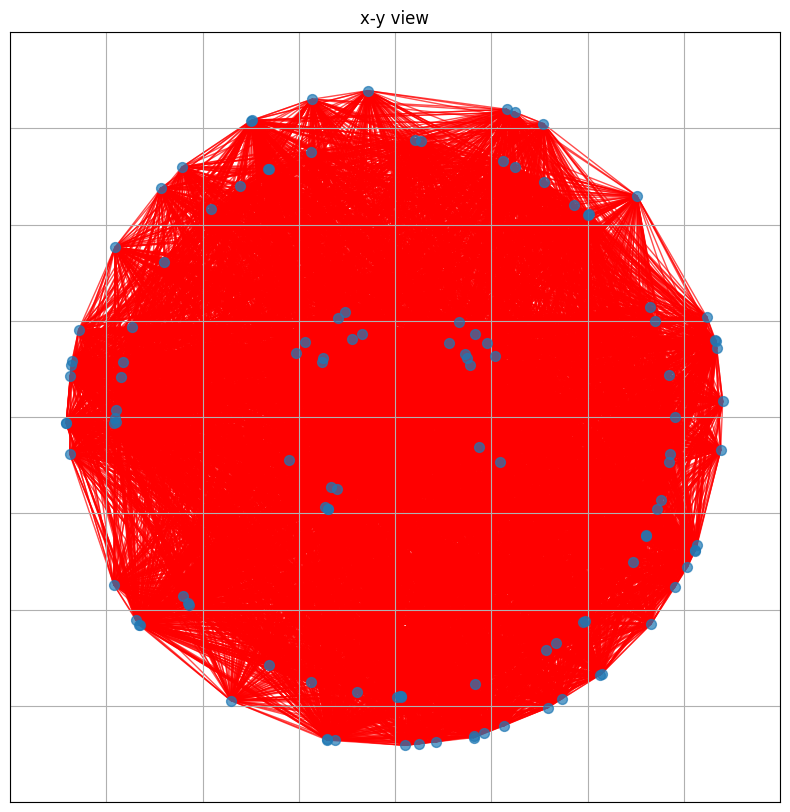

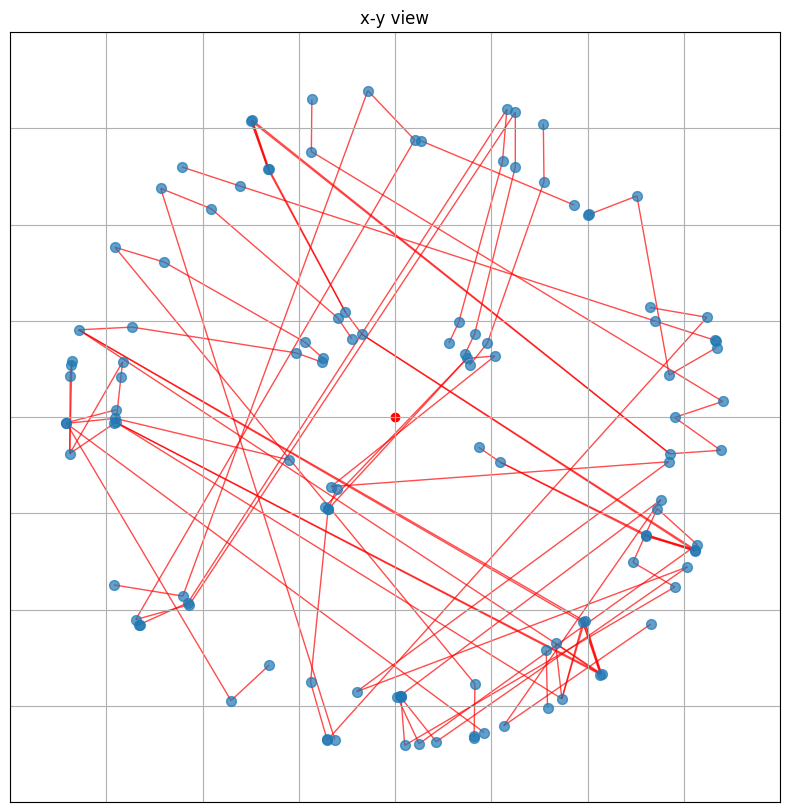

In [26]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric import utils
from torch_geometric.data import Data

def visualize_mu3e_graph(graph, hits):
    print(f'Number of nodes: {graph.num_nodes}')
    print(f'Number of edges: {graph.num_edges}')
    #print(f'Average node degree: {graph.num_edges / graph.num_nodes:.2f}') 
    #print(f'Has isolated nodes: {graph.has_isolated_nodes()}')
    #print(f'Has self-loops: {graph.has_self_loops()}')
    #print(f'Is undirected: {graph.is_undirected()}')
    #print('Edges:',graph.edge_index)
    
    g = utils.to_networkx(graph, to_undirected=True)

    pos_x_y = hits[['x', 'y']].T.to_dict()
    pos_x_y = {node_num: np.array([value['x'], value['y']]) for node_num, value in pos_x_y.items()}
    
    pos_y_z = hits[['y', 'z']].T.to_dict()
    pos_y_z = {node_num: np.array([value['y'], value['z']]) for node_num, value in pos_y_z.items()}

    fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
    ax1.set_title('x-y view')
    ax1.set_aspect('equal')
    ax1.scatter(x=0,y=0, color='red')
    ax1.grid()
    ax1.set_xlim(-100,100)
    ax1.set_ylim(-100,100)

    nx.draw_networkx(g, pos=pos_x_y, node_size=50, with_labels=False, edge_color="r", alpha=0.7, ax=ax1)

dir = '/mnt/data1/karres/cosmics_test/feature_store_cosmic_michel/valset/'
uncut = torch.load(dir+'fc_uncut/event000000109-fc_graph.pyg')
laddercut = torch.load(dir+'fc_ladder_cut/event000000109-fc_graph.pyg')
bothcut = torch.load(dir+'fc_both_cut/event000000109-fc_graph.pyg')
truth = torch.load(dir+'truth_graphs/event000000109-graph.pyg')

raw_hits = pd.read_csv(dir+'csv/event000000109-truth.csv')

print('Visualization ')
visualize_mu3e_graph(uncut, raw_hits)
visualize_mu3e_graph(laddercut, raw_hits)
visualize_mu3e_graph(bothcut, raw_hits)
visualize_mu3e_graph(truth, raw_hits)



Number of nodes: 120
Number of edges: 189


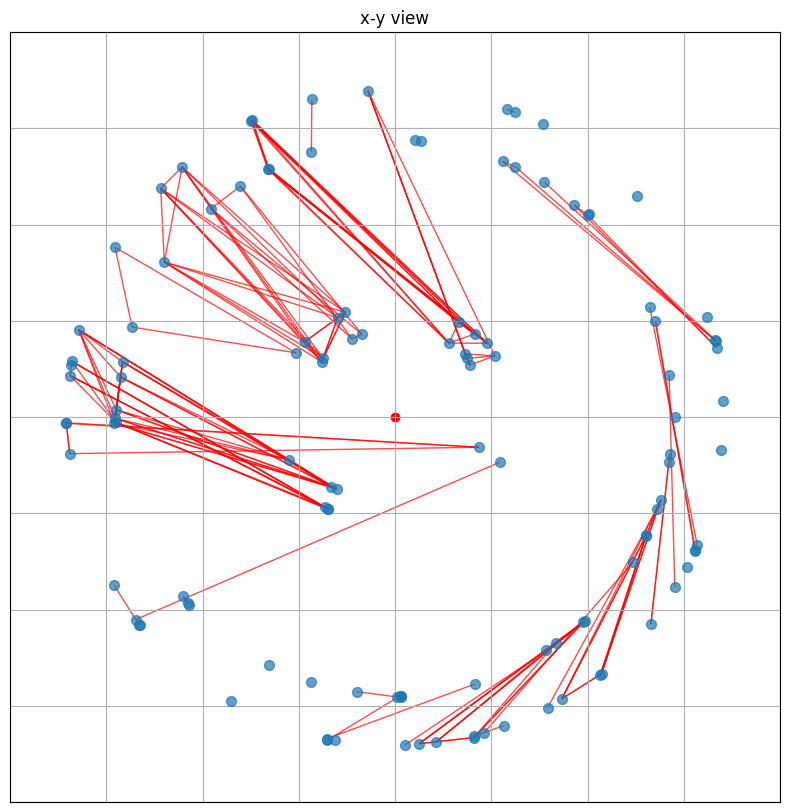

In [36]:
def graph_difference(graph1, graph2):
    edges_1 = graph1.edge_index.cpu().numpy()
    edges_2 = graph2.edge_index.cpu().numpy()

    set1 = {tuple(x) for x in edges_1.T}
    set2 = {tuple(x) for x in edges_2.T}

    difference = set1 - set2
    difference = np.array(list(difference)).T
    difference = torch.from_numpy(difference)

    graph1.edge_index = difference

    return graph1

visualize_mu3e_graph(graph_difference(uncut, laddercut), raw_hits)


In [10]:
data = {
    'data1': [3,12,5,1,5,7,1],
    'data2': [45,2,8,2,31,8,5]
}

dataframe = pd.DataFrame(data)

dataframe = dataframe.sort_values("data1").reset_index(drop=False)
print(dataframe)

   index  data1  data2
0      3      1      2
1      6      1      5
2      0      3     45
3      2      5      8
4      4      5     31
5      5      7      8
6      1     12      2


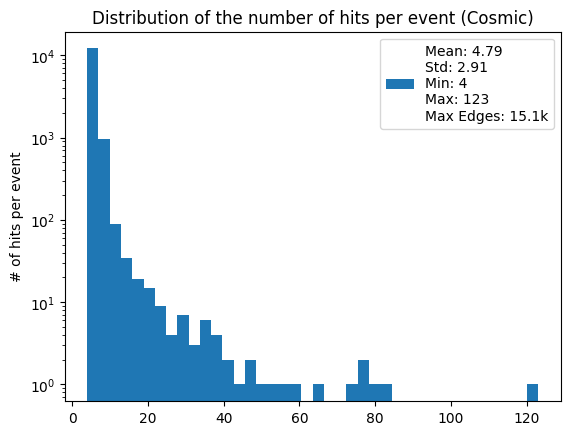

Event with most hits: 1208
Event with least hits: 18519


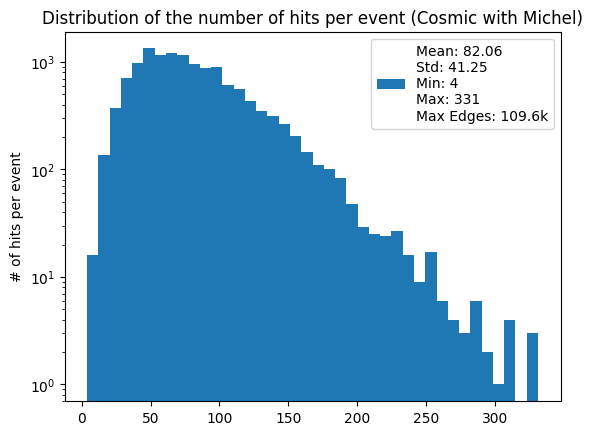

Event with most hits: 13584
Event with least hits: 14658


In [11]:
import matplotlib.pyplot as plt 
import numpy as np

def event_histogram(dataframe, name):
    event_count = dataframe['event'].value_counts()

    plt.hist(event_count.tolist(), bins=40)
    plt.ylabel('# of hits per event')
    plt.yscale('log')
    plt.title('Distribution of the number of hits per event ('+name+')')

    # Calculate statistics
    mean = np.mean(event_count)
    std = np.std(event_count)
    min_val = np.min(event_count)
    max_val = np.max(event_count)

    # Create legend
    legend_text = f"Mean: {mean:.2f}\nStd: {std:.2f}\nMin: {min_val}\nMax: {max_val}"
    max_edges = max_val ** 2
    legend_text += f"\nMax Edges: {round(max_edges/1000,1)}k"
    plt.legend([legend_text])

    plt.show()

dir1 = '/mnt/data1/karres/cosmics_test/cosmics_data/cosmic_f1.csv'
dir2 = '/mnt/data1/karres/cosmics_test/cosmics_data/cosmic_michel_f2.csv'

cosmic = pd.read_csv(dir1)
michel = pd.read_csv(dir2)

event_histogram(cosmic, 'Cosmic')
print('Event with most hits:', cosmic['event'].value_counts().idxmax())
print('Event with least hits:', cosmic['event'].value_counts().idxmin())
print('========================================================================')
event_histogram(michel, 'Cosmic with Michel')
print('Event with most hits:', michel['event'].value_counts().idxmax())
print('Event with least hits:', michel['event'].value_counts().idxmin())


In [12]:
from itertools import combinations
import pandas as pd
import numpy as np

example = {'hit_id': [1, 2, 3],
           'x': [1, 2, 3],
           'y': [4, 5, 6],
           'z': [7, 8, 9]}
dataframe = pd.DataFrame(example)

combinations = list(combinations(dataframe['hit_id'], 2))

print(np.array(combinations).T)

[[1 1 2]
 [2 3 3]]


In [13]:
import pandas as pd
from itertools import combinations
import numpy as np

df = pd.DataFrame({'Column': [0, 1, 2, 3]})

combs = np.array(list(combinations(df['Column'], 2))).T
print(combs)


#cut für ladder ids checken -> wieviel hits pro ladder id
#graph eff and purity after cuts

[[0 0 0 1 1 2]
 [1 2 3 2 3 3]]


In [14]:
import numpy as np
import pandas as pd


fc_edges = np.array([[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]])
print(fc_edges)

hits = {'hit_id': [0,1,2,3],
        'ladder_id': [1,1,2,3]}
hits = pd.DataFrame(hits)

# Create a dictionary mapping hit_id to ladder_id
ladder_id_dict = hits.set_index('hit_id')['ladder_id'].to_dict()

# Create a new list to store the edges to keep
new_fc_edges = []

for edge in fc_edges:
    # Get the ladder_id for each hit_id in the edge
    ladder_id1 = ladder_id_dict.get(edge[0])
    ladder_id2 = ladder_id_dict.get(edge[1])

    # Only add the edge to new_fc_edges if the ladder_ids are different
    if ladder_id1 != ladder_id2:
        new_fc_edges.append(edge)

# Replace fc_edges with new_fc_edges
fc_edges = np.array(new_fc_edges)

print(fc_edges)

[[0 1]
 [0 2]
 [0 3]
 [1 2]
 [1 3]
 [2 3]]
[[0 2]
 [0 3]
 [1 2]
 [1 3]
 [2 3]]


trainset
Maximum amount of edges cut: 2604
Maximum percentage of edges cut: 36.42 %

valset
Maximum amount of edges cut: 2178
Maximum percentage of edges cut: 20.77 %

testset
Maximum amount of edges cut: 1390
Maximum percentage of edges cut: 21.82 %



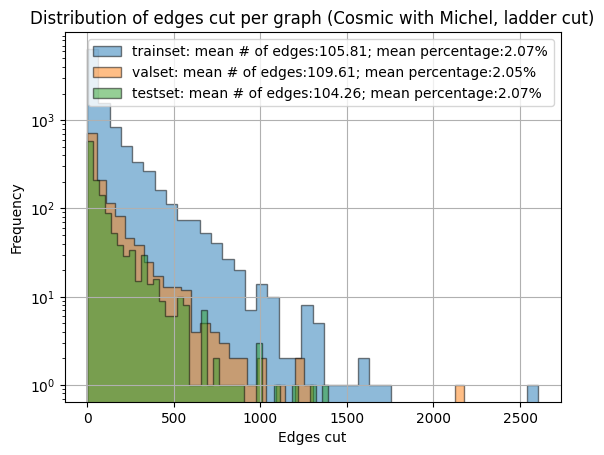

Mean purity: 9.24
Mean purity (uncut): 9.11

trainset
Maximum amount of edges cut: 1465
Maximum percentage of edges cut: 75.48 %

valset
Maximum amount of edges cut: 589
Maximum percentage of edges cut: 56.91 %

testset
Maximum amount of edges cut: 251
Maximum percentage of edges cut: 13.33 %



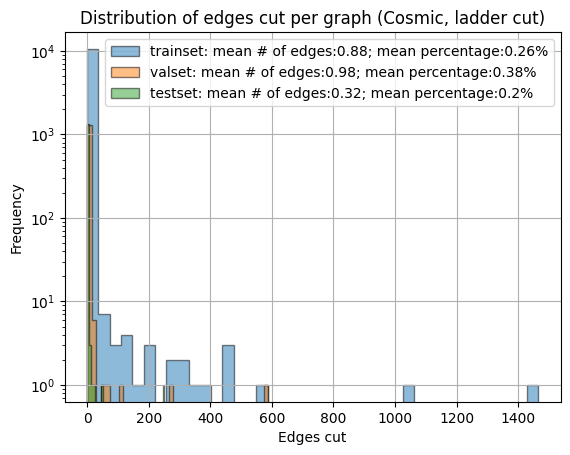

Mean purity: 58.29
Mean purity (uncut): 58.24



In [2]:
from torch_geometric import utils
import torch
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt

dir1 = '/mnt/data1/karres/cosmics_test/feature_store_cosmic_michel'
dir2 = '/mnt/data1/karres/cosmics_test/feature_store_cosmic'
 

def edge_cuts(feature_store, set, sample):
    path = os.path.join(feature_store, set)

    path1 = os.path.join(path, 'fc_uncut') #fc graphs without cuts
    path2 = os.path.join(path, 'fc_both_cut') #fc graphs with both cuts
    path3 = os.path.join(path, 'truth_graphs') #truth graphs
    path4 = os.path.join(path, 'fc_ladder_cut') #fc graphs with ladder cut only
    
    edges_fc = []
    edges_fc_both_cut = []    
    edges_fc_ladder_cut = []
    edges_truth = []
    
    

    #Read out the number of edges for each graph in each set
    #FC graphs without cuts
    for fc_graph in glob.glob(path1+'/*.pyg'):
        data1 = torch.load(fc_graph)
        edges_fc.append(data1.num_edges)

    #FC graphs with both cuts
    for fc_graph_both_cut in glob.glob(path2+'/*.pyg'):
        data2 = torch.load(fc_graph_both_cut)
        edges_fc_both_cut.append(data2.num_edges)

    #Truth graphs
    for truth_graph in glob.glob(path3+'/*.pyg'):
        data3 = torch.load(truth_graph)
        edges_truth.append(data3.num_edges)

    #FC graphs with ladder cut only
    for fc_graph_ladder_cut in glob.glob(path4+'/*.pyg'):
        data4 = torch.load(fc_graph_ladder_cut)
        edges_fc_ladder_cut.append(data4.num_edges)

    #Difference between the number of edges in the FC graphs with both cuts and the FC graphs with ladder cut only
    edge_diff = np.array(edges_fc) - np.array(edges_fc_ladder_cut)
    mean = round(np.mean(edge_diff),2)

    #Calculate the percentage of edges cut
    ratio = 100 - np.array(edges_fc_ladder_cut)/np.array(edges_fc)*100
    ratio_mean = np.mean(ratio)



    plt.hist(edge_diff, bins=40, 
             label=set+': mean # of edges:'+str(mean)+'; mean percentage:'+str(round(ratio_mean,2))+'%', 
             alpha=0.5, edgecolor='black', histtype='stepfilled')

    # Customize the plot
    plt.xlabel('Edges cut')
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.legend()
    plt.title('Distribution of edges cut per graph ('+sample+', ladder cut)')
    plt.grid(True)
    plt.legend()


    print(set)
    print('Maximum amount of edges cut:', np.max(edge_diff))
    print('Maximum percentage of edges cut:', round(np.max(ratio),2),'%')
    print()

    purity_cut = np.array(edges_truth)/np.array(edges_fc_ladder_cut)*100
    purity = np.array(edges_truth)/np.array(edges_fc)*100

    purity_cut_mean = round(np.mean(purity_cut),2)
    purity_mean = round(np.mean(purity),2)

    #print('Efficiency:', efficiency_mean)
    #print('Efficiency (uncut):', efficiency_uncut_mean)

    return purity_cut_mean, purity_mean

def calc_purity(dir, sample):
    purity_list = []
    for set in ['trainset', 'valset', 'testset']:
        purity, purity_uncut = edge_cuts(dir, set, sample)
        purity_list.append([purity, purity_uncut])

    plt.show()

    print('Mean purity:', round(np.mean(purity_list, axis=0)[0],2))
    print('Mean purity (uncut):', round(np.mean(purity_list, axis=0)[1],2))
    print()


calc_purity(dir1, 'Cosmic with Michel')
calc_purity(dir2, 'Cosmic')

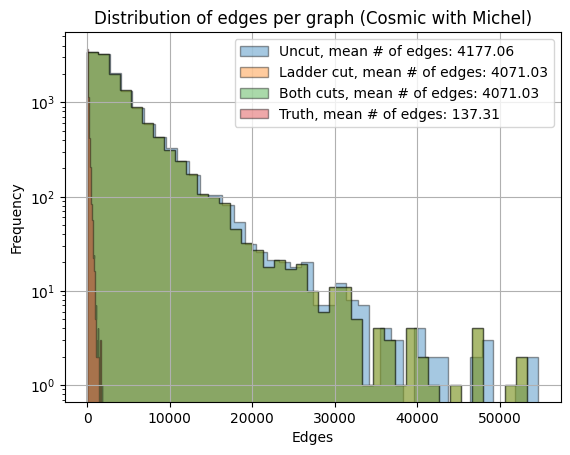

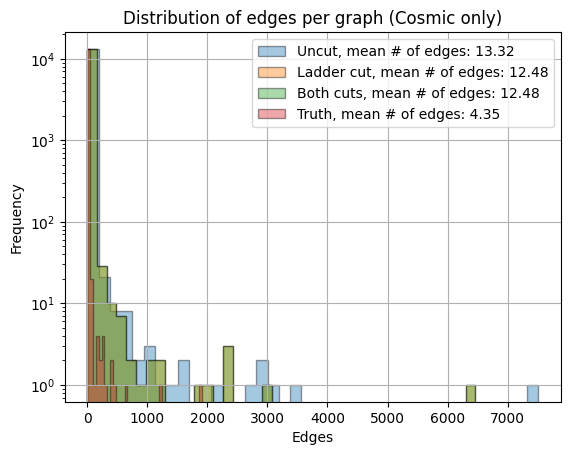

In [4]:
def get_edges(feature_store, which_graphs):
    dir = '/mnt/data1/karres/cosmics_test'
    path = os.path.join(dir,feature_store)
    
    edges = []

    for set in ['trainset', 'valset', 'testset']:
        graph_dir = os.path.join(path, set, which_graphs)

        for graph in glob.glob(graph_dir+'/*.pyg'):
            data = torch.load(graph)
            edges.append(data.num_edges)

    return edges

def build_edge_histogram(feature_store, name):

    uncut = get_edges(feature_store, 'fc_uncut')
    ladder = get_edges(feature_store, 'fc_ladder_cut')
    both = get_edges(feature_store, 'fc_both_cut')
    truth = get_edges(feature_store, 'truth_graphs')

    plt.hist(uncut, bins=40, alpha=0.4, edgecolor='black', histtype='stepfilled', 
            label='Uncut, mean # of edges: '+str(round(np.mean(uncut),2)))
    plt.hist(ladder, bins=40, alpha=0.4, edgecolor='black', histtype='stepfilled', 
            label='Ladder cut, mean # of edges: '+str(round(np.mean(ladder),2)))
    plt.hist(both, bins=40, alpha=0.4, edgecolor='black', histtype='stepfilled', 
            label='Both cuts, mean # of edges: '+str(round(np.mean(both),2)))
    plt.hist(truth, bins=40, alpha=0.4, edgecolor='black',histtype='stepfilled', 
            label='Truth, mean # of edges: '+str(round(np.mean(truth),2)))

    plt.xlabel('Edges')
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.legend()
    plt.title('Distribution of edges per graph ('+name+')')
    plt.grid(True)
    plt.show()

build_edge_histogram('feature_store_cosmic_michel', 'Cosmic with Michel')
build_edge_histogram('feature_store_cosmic', 'Cosmic only')

### To Do:
#### Done:
    - Function that takes graph and gives list of distances between nodes
    - Function that takes graph and gives list of angles between nodes
    - Function that takes whole dataset and gives histogram of distances and angles between nodes
    - Function that takes whole graph dataset of truth and fully connected and gives histogram of purity and efficiency
        Function that takes truth graph and fully connected graph and gives value of purity and efficiency
    - Compute graphs and CSVs again

#### Work in Progress:
    

#### Open:
    - Check if ladder cut is correct
    - Fix directory problem
        Change output structure in mu3e_cosmic_reader.py OR Change find_evt_ids in graph_construction_stage.py
        Possible to write function to simulate correct directory structure?
    - Get acorn infer mu3e_cosmic_eval.yaml up and running
        Probably have to fix some minor errors
    - Implement efficiency/purity in eval_utils.py
    - Distance cut?
        What would be correct distance threshold?
    - Triplet cut?
        Too expensive/complicated?

In [14]:

import torch
import numpy as np
import glob
import os

def distance_between_nodes(path):
    event = torch.load(path)
    distances = []

    for edge in event.edge_index.T:
        node1_pos = event.x[edge[0]][1:]
        node2_pos = event.x[edge[1]][1:]

        distance = np.linalg.norm(node1_pos-node2_pos)
        distances.append(distance)

    return distances

def angle_between_nodes(path):
    event = torch.load(path)
    angles = []

    for edge in event.edge_index.T:
        node1_pos = event.x[edge[0]][1:]
        node2_pos = event.x[edge[1]][1:]

        diff_pos = node2_pos - node1_pos
        angle = np.arccos(diff_pos[1]/np.linalg.norm(diff_pos)) - np.pi/2

        angles.append(angle)

    return angles

def get_distances_and_angles(dir, feature_store, which_graphs):

    path = os.path.join(dir,feature_store)
    
    distances = []
    angles = []

    for set in ['trainset', 'valset', 'testset']:
        graph_dir = os.path.join(path, set, which_graphs)

        for graph in glob.glob(graph_dir+'/*.pyg'):
            distances.extend(distance_between_nodes(graph))
            angles.extend(angle_between_nodes(graph))

    return distances, angles

In [2]:
dir = '/mnt/data1/karres/cosmics_test/'

distances = []
angles = []

for type in ['fc_uncut', 'fc_both_cut','truth_graphs']:
    distances.append(get_distances_and_angles(dir, 'feature_store_cosmic', type)[0])
    angles.append(get_distances_and_angles(dir, 'feature_store_cosmic', type)[1])

'''
distances_fc, angles_fc = get_distances_and_angles(dir, 'feature_store_cosmic', 'fc_graphs')
distances_truth, angles_truth = get_distances_and_angles(dir, 'feature_store_cosmic', 'truth_graphs')
distances_fc_cut, angles_fc_cut = get_distances_and_angles(dir, 'feature_store_cosmic', 'fc_graphs_both_cut')

distances = [distances_fc, distances_fc_cut, distances_truth]
angles = [angles_fc, angles_fc_cut, angles_truth]
'''
names = ['FC w/o cuts', 'FC w/ both cuts', 'Truth']

In [6]:
import matplotlib.pyplot as plt

def plot_distance_angle(distances, angles, names, set_name):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    for distance, name in zip(distances, names):
        axs[0].hist(distance, bins=50, alpha=0.4, edgecolor='black', histtype='stepfilled', label=name)

    for angle, name in zip(angles, names):
        axs[1].hist(angle, bins=50, alpha=0.4, edgecolor='black', histtype='stepfilled', label=name)

    axs[0].legend()
    axs[0].set_title('Distribution of distances between nodes')
    axs[0].set_yscale('log')
    axs[0].set_xlabel('Distance [mm]')
    axs[0].set_ylabel('Frequency')

    axs[1].legend()
    axs[1].set_title('Distribution of angles between nodes')
    axs[1].set_yscale('log')
    axs[1].set_xlabel('Angle [rad]')
    axs[1].set_ylabel('Frequency')

    fig.suptitle('Edge properties of the '+set_name+' dataset', fontsize=16)
    plt.show()

In [25]:
def eff_pur_single_event(path_truth, path_fc):
    event_truth = torch.load(path_truth)
    event_fc = torch.load(path_fc)

    edges_truth = event_truth.edge_index.cpu().numpy()
    edges_fc = event_fc.edge_index.cpu().numpy()

    truth_set = {tuple(x) for x in edges_truth.T}
    fc_set = {tuple(x) for x in edges_fc.T}
    print(truth_set)
    print(fc_set)
    intersection = truth_set.intersection(fc_set)
    print(intersection)
    
    efficiency = len(intersection)/len(truth_set)
    purity = len(intersection)/len(fc_set)

    return efficiency, purity

def get_eff_pur(dir, feature_store, which_graphs):
    path = os.path.join(dir,feature_store)
    
    eff_list = []
    pur_list = []

    for set in ['trainset', 'valset', 'testset']:
        fc_graph_dir = os.path.join(path, set, which_graphs)
        truth_graph_dir = os.path.join(path, set, 'truth_graphs')

        fc_graphs = glob.glob(fc_graph_dir+'/*.pyg')
        truth_graphs = glob.glob(truth_graph_dir+'/*.pyg')

        for fc_graph, truth_graph in zip(fc_graphs, truth_graphs):
            eff, pur = eff_pur_single_event(truth_graph, fc_graph)
            eff_list.append(eff)
            pur_list.append(pur)

    return eff_list, pur_list

def plot_eff_pur(efficiencies, purities, names, set_name):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    for eff, name in zip(efficiencies, names):
        axs[0].hist(eff, bins=50, alpha=0.4, edgecolor='black', histtype='stepfilled', label=name+ ' mean: '+str(round(np.mean(eff),2)))

    for pur, name in zip(purities, names):
        axs[1].hist(pur, bins=50, alpha=0.4, edgecolor='black', histtype='stepfilled', label=name+ ' mean: '+str(round(np.mean(pur),2)))

    axs[0].legend()
    axs[0].set_title('Distribution of efficiencies')
    axs[0].set_yscale('log')
    axs[0].set_xlabel('Efficiency')
    axs[0].set_ylabel('Frequency')

    axs[1].legend()
    axs[1].set_title('Distribution of purities')
    axs[1].set_yscale('log')
    axs[1].set_xlabel('Purity')
    axs[1].set_ylabel('Frequency')

    fig.suptitle('Efficiency and purity of the '+set_name+' dataset', fontsize=16)
    plt.show()

In [2]:
from visualization_utils import get_distances_and_angles, get_eff_pur
dir = '/mnt/data1/karres/cosmics_test/'

dist_c, angle_c = [], []
dist_cm, angle_cm = [], []

eff_c, pur_c = [], []
eff_cm, pur_cm = [], []

#Cosmics only
for graph in ['fc_uncut', 'fc_both_cut', 'truth_graphs']:
    dist_c_new, angle_c_new = get_distances_and_angles(dir, 'feature_store_cosmic', graph)
    dist_c.append(dist_c_new)
    angle_c.append(angle_c_new)

    eff_c_new, pur_c_new = get_eff_pur(dir, 'feature_store_cosmic', graph)
    eff_c.append(eff_c_new)
    pur_c.append(pur_c_new)

#Cosmics with Michel
#for graph in ['fc_uncut', 'fc_graphs_both_cut', 'truth_graphs']:
    #dist_cm, angle_cm = get_distances_and_angles(dir, 'feature_store_cosmic_michel', graph)
    #eff_cm, pur_cm = get_eff_pur(dir, 'feature_store_cosmic_michel', graph)

In [3]:
#Plot the distance and angle distributions
names = ['FC w/o cuts', 'FC w/ both cuts', 'Truth']

plot_distance_angle(dist_c, angle_c, names, 'Cosmic')
#plot_distance_angle(dist_cm, angle_cm, names, 'Cosmic with Michel')

plot_eff_pur(eff_c, pur_c, names, 'Cosmic')
#plot_eff_pur(eff_cm, pur_cm, names, 'Cosmic with Michel')

NameError: name 'plot_distance_angle' is not defined

Efficiency: 1.0
Purity: 0.5
Number of nodes: 4
Number of edges: 3


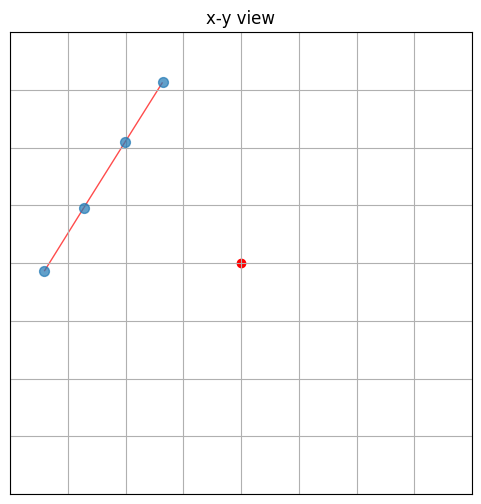

Number of nodes: 4
Number of edges: 6


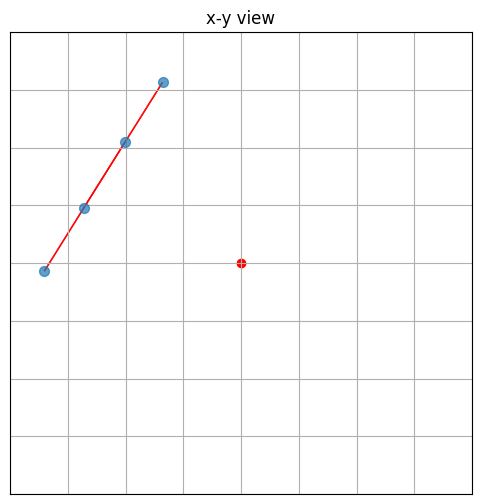

In [1]:
dir_truth = '/mnt/data1/karres/cosmics_test/feature_store_cosmic/trainset/truth_graphs/event000000002-graph.pyg'
dir_fc = '/mnt/data1/karres/cosmics_test/feature_store_cosmic/trainset/fc_uncut/event000000002-fc_graph.pyg'
from visualization_utils import *

eff, pur = eff_pur_single_event(dir_truth, dir_fc)
print('Efficiency:', eff)
print('Purity:', pur)

truth = torch.load(dir_truth)
fc = torch.load(dir_fc)
csv = pd.read_csv('/mnt/data1/karres/cosmics_test/feature_store_cosmic/trainset/csv/event000000002-truth.csv')

visualize_mu3e_graph(truth, csv)
visualize_mu3e_graph(fc, csv)

In [6]:
set1 = {(0, 1), (2, 1), (2, 3)}
set2 = {(1, 0), (2, 2), (2, 3)}

# Convert tuples to sets
set1_normalized = {frozenset(pair) for pair in set1}
set2_normalized = {frozenset(pair) for pair in set2}

# Find intersection
intersection_normalized = set1_normalized.intersection(set2_normalized)

# Convert back to tuples
intersection = {tuple(pair) for pair in intersection_normalized}

print("Intersection with (0, 1):", intersection)

Intersection with (0, 1): {(0, 1), (2, 3)}


In [22]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch_geometric import utils
import numpy as np

def visualize_mu3e_graph(graph, hits): 
    '''
    Input:  PYG graph
            CSV loaded as dataframe
    Output: Information about edges and nodes
            2D plot of the graph in x-y plane with nodes at correct position in space
    '''

    print(f'Number of nodes: {graph.num_nodes}')
    print(f'Number of edges: {graph.num_edges}')
    #print(f'Average node degree: {graph.num_edges / graph.num_nodes:.2f}') 
    #print(f'Has isolated nodes: {graph.has_isolated_nodes()}')
    #print(f'Has self-loops: {graph.has_self_loops()}')
    #print(f'Is undirected: {graph.is_undirected()}')
    #print('Edges:',graph.edge_index)
    
    g = utils.to_networkx(graph, to_undirected=True)

    #pos_x_y = hits[['x', 'y']].T.to_dict()
    #pos_x_y = {node_num: np.array([value['x'], value['y']]) for node_num, value in pos_x_y.items()}

    #print(pos_x_y)
    
    #pos_y_z = hits[['y', 'z']].T.to_dict()
    #pos_y_z = {node_num: np.array([value['y'], value['z']]) for node_num, value in pos_y_z.items()}

    fig, axs = plt.subplots(1, 1, figsize=(6, 6))
    axs.set_title('x-y view')
    axs.set_aspect('equal')
    axs.scatter(x=0,y=0, color='red')
    axs.grid()
    #axs.set_xlim(-100,100)
    #axs.set_ylim(-100,100)

    '''
    axs[1].set_title('y-z view')
    axs[1].set_aspect('equal')
    axs[1].scatter(x=0,y=0, color='red')
    axs[1].grid()
    axs[1].set_xlim(-650,650)
    axs[1].set_ylim(-100,100)
    '''
    nx.draw_networkx(g, node_size=200, with_labels=True, edge_color="r", alpha=0.7)
    #nx.draw_networkx(g, pos=pos_y_z, node_size=50, with_labels=False, edge_color="r", alpha=0.7, ax=axs[1])
    
    plt.show()

Node indices: [3.0, 5.0, 6.0, 10.0, 12.0, 13.0]
Edges: tensor([[13,  5,  6,  3, 12],
        [ 5,  6,  3, 12, 10]])
None
Number of nodes: 6
Number of edges: 5


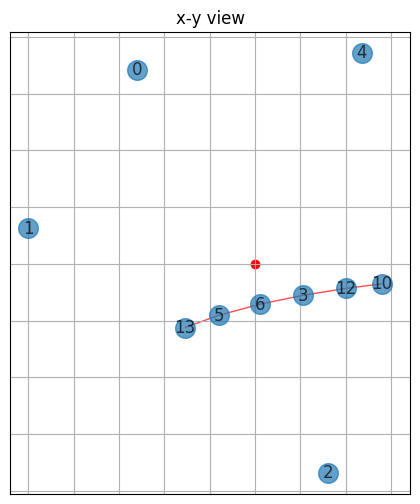

In [23]:
#from visualization_utils import visualize_mu3e_graph
import torch
import pandas as pd

dir = '/mnt/data1/karres/cosmics_test/feature_store_cosmic/trainset/truth_graphs/event000000139-graph.pyg'
dir2 = '/mnt/data1/karres/cosmics_test/feature_store_cosmic/trainset/fc_uncut/event000000139-fc_graph.pyg'
dir3 = '/mnt/data1/karres/cosmics_test/feature_store_cosmic/trainset/fc_both_cut/event000000139-fc_graph.pyg'

pyg = torch.load(dir)
#pyg2 = torch.load(dir2)
#pyg3 = torch.load(dir3)

csv = pd.read_csv('/mnt/data1/karres/cosmics_test/feature_store_cosmic/trainset/csv/event000000139-truth.csv')

print('Node indices:', pyg.x[:,0].tolist())
print('Edges:', pyg.edge_index)
print(pyg.edge_attr)

visualize_mu3e_graph(pyg, csv)
#visualize_mu3e_graph(pyg2, csv)
#visualize_mu3e_graph(pyg3, csv)

In [2]:
import visualization_utils as vu

dir = '/mnt/data1/karres/cosmics_test/'

distances, angles = vu.get_distances_and_angles_multi(dir, 'feature_store_cosmic', ['fc_uncut', 'fc_both_cut', 'truth_graphs'])
vu.plot_distance_angle(distances, angles, ['FC w/o cuts', 'FC w/ both cuts', 'Truth'], 'Cosmic')

IndexError: index 6 is out of bounds for dimension 0 with size 4

### To Do:
#### Done:
    - Function that takes graph and gives list of distances between nodes
    - Function that takes graph and gives list of angles between nodes
    - Function that takes whole dataset and gives histogram of distances and angles between nodes
    - Function that takes whole graph dataset of truth and fully connected and gives histogram of purity and efficiency
        Function that takes truth graph and fully connected graph and gives value of purity and efficiency
    - Compute graphs and CSVs again

#### Work in Progress:
    

#### Open:
    - Fix truth graph problem
    - Fix directory problem
        Change output structure in mu3e_cosmic_reader.py OR Change find_evt_ids in graph_construction_stage.py
        Possible to write function to simulate correct directory structure?
    - Get acorn infer mu3e_cosmic_eval.yaml up and running
        Probably have to fix some minor errors
    - Implement efficiency/purity in eval_utils.py
    - Distance cut?
        What would be correct distance threshold?
    - Triplet cut?
        Too expensive/complicated?